# Selection of components for the field of light


In [1]:
%matplotlib notebook
import math
from scipy import integrate
import pandas as pd
import functools
import LEDs
import scipy.ndimage.filters as sp_filters
from LEDs import CSVDatabase, LED, Optics, LightField
import pickle
import itertools

#
# Constants
#
sun_ppfd = 2200  # PPFD of the Sun, the one we want to mimick
shelf_surface = 0.51 * 0.72  # The surface to cover at sun PPFD
cost_kwh = 0.26  # Cost of electricity per kWh, considering both supply and delivery charges...
moles_per_m2_per_day = 50  # Number of moles of photon per meter square per day 

Let's first load the component databases

In [2]:
optics_db = CSVDatabase('Light/Optics.csv')
led_db = CSVDatabase('Light/LEDs.csv')
led_db.db.set_index(['brand', 'model', 'serial_number'])

$  current   cri  \
brand     model          serial_number                                       
Cree      CXA2           CXB2530                    12.8340     0.80  70.0   
                         CXB3070-0000-000N0UZ230G   32.9500     1.90  90.0   
                         CXB3070-0000-000N0HAD30G   36.0600     1.90  80.0   
                         CXB3590-0000-000R0BCD50e   41.1900     2.40  70.0   
          MH             MHDEWT-0000-000N0HG430G     2.5650     0.80  80.0   
Bridgelux Vero 10        BXRC-50C1001-D-74           3.5800     0.35  70.0   
                          BXRC-40E1000-D-73          3.5800     0.35  80.0   
                          BXRC-30G1000-D-73          3.5800     0.35  90.0   
                         BXRC-30E1000-D-73           3.5800     0.35  80.0   
          H              BXRC-40E1000-D-73          15.1100     2.50  80.0   
          Vero 13        BXRC-30E2000-D-73           5.8200     0.50  80.0   
                         BXRC-27E2000-D-73           5.8200     0.50  80.0   
          Vero 18        BXRC-30E4000-D-73           9.7900     1.05  80.0   
          V22            BXRE-30e6500-C-73          13.3000     0.50  80.0   
          Vero 10        BXRC-30G1000-B-23           3.6850     0.35  90.0   
                         BXRC-30G1000-C-73           4.5030     0.33  90.0   
Citizen   CLU731         CLU731-1210C4-403M2K1      21.5000     1.75  70.0   
          CLU0           CLU038-1206C4-30AL7K3      14.5100     0.54  70.0   
                         CLU028-1203C4-30AL7K3       6.0800     0.27  70.0   
                         CLU048-1212C4-30AL7K3      28.4900     1.08  70.0   
                         CLU036-1205C1-30AL7G4       9.4325     0.45  70.0   
                         CLU028-1201C4-30AL7K3       3.5700     0.09  70.0   
                         CLU038-1205C4-30AL7K3      12.1200     0.45  70.0   
Luminus   XNova          CHM-11-30-80-36-XH20-F3-3   4.8300     0.72  80.0   
                         CHM-11-30-90-36-XH00-F2-3   6.7300     0.96  90.0   
                         CHM-6-30-80-27-XH20-F3-3    3.6500     0.48  80.0   
Citizen   CLU-048-1212C4 CLU048-1211C4-30AL7M4-F1    9.8800     0.99  70.0   
Bridgelux V22            BXRE-30E6500-D-73           9.6300     1.40  80.0   

                                                    temperature  voltage  \
brand     model          serial_number                                     
Cree      CXA2           CXB2530                         4000.0     36.0   
                         CXB3070-0000-000N0UZ230G        3000.0     36.0   
                         CXB3070-0000-000N0HAD30G        3000.0     36.0   
                         CXB3590-0000-000R0BCD50e        5000.0     36.0   
          MH             MHDEWT-0000-000N0HG430G         3000.0      9.0   
Bridgelux Vero 10        BXRC-50C1001-D-74               5000.0     26.0   
                          BXRC-40E1000-D-73              4000.0     26.0   
                          BXRC-30G1000-D-73              3000.0     25.3   
                         BXRC-30E1000-D-73               3000.0     25.3   
          H              BXRC-40E1000-D-73               4000.0     35.1   
          Vero 13        BXRC-30E2000-D-73               3000.0     30.9   
                         BXRC-27E2000-D-73               2700.0     30.9   
          Vero 18        BXRC-30E4000-D-73               3000.0     28.3   
          V22            BXRE-30e6500-C-73               3000.0     48.8   
          Vero 10        BXRC-30G1000-B-23               3000.0     26.5   
                         BXRC-30G1000-C-73               3000.0     33.7   
Citizen   CLU731         CLU731-1210C4-403M2K1           4000.0     37.6   
          CLU0           CLU038-1206C4-30AL7K3           3000.0     34.6   
                         CLU028-1203C4-30AL7K3           3000.0     34.6   
                         CLU048-1212C4-30AL7K3           3000.0     34.6   
                         CLU036-1205C1-30AL7G

Now, let's generate all the optics-LED pairs we have in file

In [3]:
pairs = list()
for l in led_db:
    for o in optics_db.find(led_brand=l['brand'], led_model=l['model']).iterrows():
        try:
            led = LED(l, z=0.1)
            optics = Optics(o[1])
            optics.estimate()
            led.optics = optics
            pairs.append(led)
        except FileNotFoundError:
            pass
pairs

Let's look at one of our pairs

In [4]:
pair = pairs[-1]

pair.description, pair.optics.description

($                                         9.63
 current                                    1.4
 cri                                         80
 temperature                               3000
 voltage                                   33.4
 brand                                Bridgelux
 lumens                                    6846
 serial_number                BXRE-30E6500-D-73
 note                                       NaN
 ppf                                        NaN
 model                                      V22
 spectrum         Bridgelux V22 3000K 80CRI.csv
 Name: 27, dtype: object, index                            9
 brand                    Bridgelux
 series                         V22
 model                          NaN
 serial_number                  NaN
 led_brand                Bridgelux
 led_model                      V22
 efficiency                       1
 file             Bridgelux V22.csv
 Name: 2, dtype: object)

In [5]:
pair.ppf

102.03227889278139

We can also look at the spectral distribution of that LED

<IPython.core.display.Javascript object>


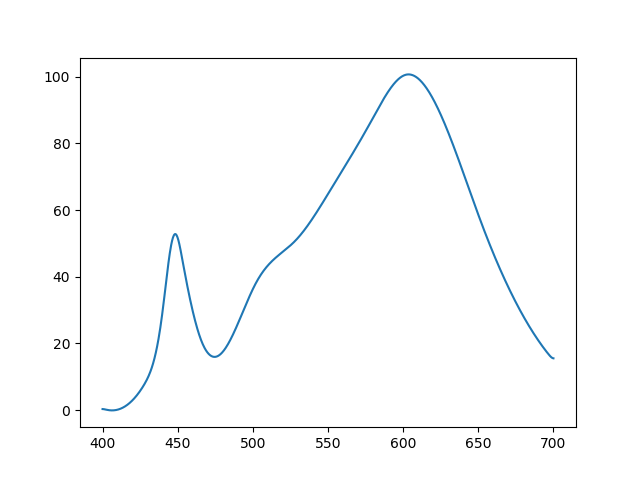

In [6]:
plt.figure()
x = np.linspace(400, 700, 1000)
plt.plot(x, sp_filters.gaussian_filter1d(pair.spectrum(x), 5))

## Axial photoactive photon flux (PPF) distribution
Our goal is to obtain the photon flux distribution on a given surface. To do so, we'll first define the number of photon at a given angle away from the center of the LED. This is because manufacturers often/always give the light distribution information of their LED as _relative intensity_ as a function of _degrees_. We can convert this information into _PPF_ as a function of _degrees_ by dividing the the function by its area under the curve, making it unitless, and then multiplying it by the PPF of the LED, making it a _PPF_ as a function of _degrees_ distribution.

<IPython.core.display.Javascript object>


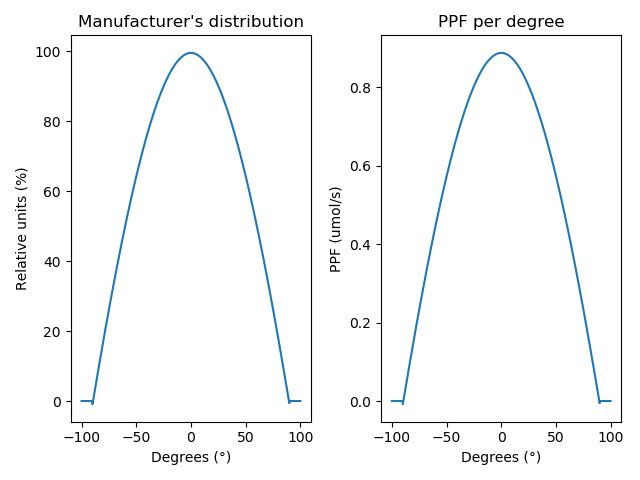

In [8]:
plt.figure()
x = np.linspace(-100, 100, 1000)
plt.subplot(121)
plt.title("Manufacturer's distribution")
plt.ylabel("Relative units (%)")
plt.xlabel('Degrees (°)')
plt.plot(x, pair.ard(x))
plt.subplot(122)
plt.title('PPF per degree')
plt.ylabel('PPF (umol/s)')
plt.xlabel('Degrees (°)')
plt.plot(x, pair.axial_photon_flux_distribution(x))
plt.tight_layout()

# Distal photoactive photon flux density (PPFD) distribution
We can calculate the the PPF/° of our LED, but this information is not very practical. We're rather concerned with knowing how much light (in umol/s/m^2) we have at a given location. To get this information, we simply have to convert the axial information into distal information, a basic geometry problem.

In [17]:
pair.distal_photon_flux_density_distribution(0.001, 0.001, 1)

(1.001, 1.001) (-0.999, -0.999) 0.008062542143534301 1.4156277759354678 1.412799348810722 0.02513274122871488 0.00716084863485908


0.2849211142427076

# Everything underneath is not known to be functional!

In [11]:
plt.figure()
center = (0, 0)
x, y = np.meshgrid(np.linspace(-1000, 1000, 1000), np.linspace(-1000, 1000, 1000))

field = pair.distal_photon_flux_density_distribution(x, y)

contours = plt.contourf(x, y, field)
plt.axis('equal')
plt.plot(center[0], center[1], 'rx')
plt.colorbar()


<IPython.core.display.Javascript object>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plt.figure()
center = (0, 0)
x, y = np.meshgrid(np.linspace(-0.36, 0.36, 1000), np.linspace(-0.255, 0.255, 1000))
field = pair.distal_flux_density_distribution(x, y, 0.1, center)
# plt.imshow(field)
contours = plt.contourf(x, y, field)
plt.plot(center[0], center[1], 'rx')
# plt.clabel(contours, inline=True, fontsize=8)
plt.colorbar()

In [ ]:
with open('Light/pairs.pckl', 'wb') as f:
    pickle.dump(pairs, f)

## Generate areas under the curve at different z values
Calculating the AUC is slow. I can generate a bunch of them for all the pairs, so that I can move forward faster, later on.

In [ ]:
with open('Light/pairs.pckl', 'rb') as f:
    pairs = pickle.load(f)

I'll calculate at different levels of precisions so that I can move forward with coarser zs without having to way too long. I don't loose time doing it because it won't recalculate the AUCs at a given z if it was already calculated.

In [ ]:
coarse_zs = np.arange(0.1, 0.9, 0.1)
medium_zs = np.arange(0.1, 0.9, 0.05)
smooth_zs = np.arange(0.1, 0.9, 0.01)
z_sets = [coarse_zs, medium_zs, smooth_zs]

In [ ]:
for zs in z_sets:
    for z in zs:
        for pair in pairs:
            # Calculate
            pair.optics.area_under_drd(z)

            # Save the list every single time, because I'll probably kill the calculations several times
            with open('Light/pairs.pckl', 'wb') as f:
                pickle.dump(pairs, f)

In [ ]:
for pair in pairs:
    display(pair.optics.integral_drd)

## Generate fields of light

In [ ]:
with open('Light/pairs.pckl', 'rb') as f:
    leds = pickle.load(f)

In [ ]:
for i, led in enumerate(leds):
    display(i, led.description, led.optics.description)

In [ ]:
def uniform_spacing_rectangle(w, d, n):
    """
    Generate a light field by positioning LEDS equidistantly in a rectangular fashion
    
    Should look into this to be able to use the exact number of LEDs: https://www.google.com/search?q=packing+circles+in+a+square&oq=packing+circles+in+a+square&gs_l=psy-ab.3..0j0i22i30k1l3.260412.264878.0.265455.27.24.0.0.0.0.291.3337.0j15j5.20.0....0...1.1.64.psy-ab..7.20.3331...35i39k1j0i67k1j0i20k1.0.EUPmkYp_Qy4
  
    w: width of the illumination area (m)
    d: depth of the illumination area (m)
    h: height of the LEDs from the illumination area (m)
    n: number of LEDs in the system
    """
    n_w = int(round(np.sqrt(w*n/d),0))
    n_d = int(round(n / n_w))
    x, y = np.meshgrid(range(n_w), range(n_d))
    unit_w = w / n_w
    unit_d = d / n_d
    positions = np.stack([(x.ravel() + 0.5) * unit_w, (y.ravel() + 0.5) * unit_d], 1)
    return positions, n_w * n_d

In [ ]:
led = leds[16]
d = 0.51
w = 0.72
z = 0.2
positions = uniform_spacing_rectangle(w, d, 12)[0]
positions = [(x, y, z, (0, 0), led) for x, y in positions]
L = LightField(positions)

In [ ]:
plt.figure()
plt.contourf(L.estimate(w, d))
plt.colorbar()

In [ ]:
led.optics.integral_drd

In [ ]:
plt.figure()
x = np.linspace(-0.35, 0.35, 100)
y = np.linspace(-0.25, 0.25, 100)
x, y = np.meshgrid(x, y)
z = led.optics.drd(x, y, z)
# plt.axes().set_aspect('equal')
plt.pcolor(x, y, z)
plt.colorbar()

**I have an issue with my AUC calculation. Probably, the boundaries are not working. I need to look into this.**